## PARTE4

In [ ]:
import os, re, glob, shutil
import numpy as np
import rasterio



input_dir  = "/content/drive/MyDrive/Colab_Notebooks/images/Amatitlan/"
out_index  = os.path.join(input_dir, "cyano_index")
out_rgb    = os.path.join(input_dir, "cyano_rgb")
os.makedirs(out_index, exist_ok=True)
os.makedirs(out_rgb,   exist_ok=True)


BAND_ORDER = ["B02","B03","B04","B05","B07","B08","B8A","B11","B12"]


def safe_div(a,b):
    return np.where(np.abs(b)>1e-10, a/b, 0.0)

def water_mask(B):
    # Parámetros del evalscript
    MNDWI_thr = 0.42
    NDWI_thr  = 0.40

    r, g, b = B["B04"], B["B03"], B["B02"]
    nir, sw1, sw2 = B["B08"], B["B11"], B["B12"]

    ndvi  = safe_div(nir - r,   nir + r)
    mndwi = safe_div(g   - sw1, g   + sw1)
    ndwi  = safe_div(g   - nir, g   + nir)
    ndwi_leaves = safe_div(nir - sw1, nir + sw1)
    aweish  = b + 2.5*g - 1.5*(nir + sw1) - 0.25*sw2
    aweinsh = 4*(g - sw1) - (0.25*nir + 2.75*sw1)

    ws = ( (mndwi > MNDWI_thr) | (ndwi > NDWI_thr) |
           (aweinsh > 0.1879) | (aweish > 0.1112) |
           (ndvi < -0.2) | (ndwi_leaves > 1) )

    # Filtro urbano/suelo desnudo
    dbsi = safe_div((sw1 - g), (sw1 + g)) - ndvi
    ws = ws & ~((aweinsh <= -0.03) | (dbsi > 0))
    return ws

def compute_fai(B):
    # FAI(R, RE2, NIRnarrow) del evalscript
    R   = B["B04"]; RE2 = B["B07"]; NIRn = B["B8A"]
    return (RE2 - R - (NIRn - R) * (783 - 665) / (865 - 665))

def compute_chl(B):
    # NDCI con B05 (RE1) y B04 (R)
    R = B["B04"]; RE1 = B["B05"]
    ndci = safe_div(RE1 - R, RE1 + R)
    # Polinomio del script
    chl = 826.57*ndci**3 - 176.43*ndci**2 + 19*ndci + 4.071
    return chl

def colorize(chl, water, fai, B):
    # Emula la rampa del evalscript; no-agua: true color (3*R,G,B)
    R, G, BL = B["B04"], B["B03"], B["B02"]
    h, w = chl.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)

    # True color para no-agua
    tc = np.stack([3*R, 3*G, 3*BL], axis=-1)
    tc = np.clip(tc, 0, 1)
    rgb[~water] = (tc[~water]*255).astype(np.uint8)

    # En agua con vegetación flotante (FAI>0.08): naranja
    veg = water & (fai > 0.08)
    rgb[veg] = np.array([233,72,21], dtype=np.uint8)

    # En agua sin vegetación flotante: color por umbral de chl
    mask = water & ~veg
    c = chl.copy()

    def set_range(lo, hi, col):
        m = mask & (c >= lo) & (c < hi)
        rgb[m] = np.array(col, dtype=np.uint8)

    # Tramos del evalscript (resumidos 1:1)
    set_range(0,   0.5,  [0,0,255])
    set_range(0.5, 1,    [0,0,255])
    set_range(1,   2.5,  [0,59,255])
    set_range(2.5, 3.5,  [0,98,255])
    set_range(3.5, 5,    [15,113,141])
    set_range(5,   7,    [14,141,120])
    set_range(7,   8,    [13,141,103])
    set_range(8,   10,   [30,226,28])
    set_range(10,  14,   [42,226,28])
    set_range(14,  18,   [68,226,28])
    set_range(18,  20,   [68,226,28])
    set_range(20,  24,   [134,247,0])
    set_range(24,  28,   [140,247,0])
    set_range(28,  30,   [205,237,0])
    set_range(30,  38,   [208,240,0])
    set_range(38,  45,   [208,240,0])
    set_range(45,  50,   [251,210,3])
    set_range(50,  75,   [248,207,2])
    set_range(75,  90,   [134,247,0])
    set_range(90,  100,  [245,164,9])
    set_range(100, 150,  [240,159,8])
    set_range(150, 250,  [237,157,7])
    set_range(250, 300,  [239,118,15])
    set_range(300, 350,  [239,101,15])
    set_range(350, 450,  [239,100,14])
    set_range(450, 500,  [233,72,21])

    # >=500: naranja
    m = mask & (c >= 500)
    rgb[m] = np.array([233,72,21], dtype=np.uint8)

    return rgb

def load_bands(path, band_order=BAND_ORDER):
    with rasterio.open(path) as src:
        if src.count < len(band_order):
            raise ValueError(f"El TIF tiene {src.count} bandas, se requieren {len(band_order)}: {band_order}")
        B = {}
        for i, name in enumerate(band_order, start=1):
            B[name] = src.read(i).astype(np.float32)
            # Normaliza a reflectancia si vienen en 0..10000 (típico L2A)
            if B[name].max() > 1.5:
                B[name] /= 10000.0
        profile = src.profile
    return B, profile


tifs = sorted(glob.glob(os.path.join(input_dir, "*.tif")))
print(f"Encontrados {len(tifs)} GeoTIFF")

for tif in tifs:
    try:
        B, profile = load_bands(tif)
        for k in ["B02","B03","B04","B05","B07","B08","B8A","B11","B12"]:
            assert k in B, f"Falta {k} en {os.path.basename(tif)}"

        wmask = water_mask(B)
        fai   = compute_fai(B)
        chl   = compute_chl(B)

        # Deja NaN fuera de agua o con vegetación flotante
        chl_masked = np.where(wmask & (fai <= 0.08), chl, np.nan).astype(np.float32)

        # Guarda GeoTIFF (1 banda)
        out_tif = os.path.join(
            out_index,
            re.sub(r"\.tif$", "_CYANO.tif", os.path.basename(tif))
        )
        prof = profile.copy()
        prof.update(count=1, dtype="float32")
        with rasterio.open(out_tif, "w", **prof) as dst:
            dst.write(chl_masked, 1)

        # Guarda PNG colorizado
        rgb = colorize(chl, wmask, fai, B)
        out_png = os.path.join(
            out_rgb,
            re.sub(r"\.tif$", "_CYANO.png", os.path.basename(tif))
        )
        import imageio.v2 as iio
        iio.imwrite(out_png, rgb)

        print(f"✓ {os.path.basename(tif)} -> {os.path.basename(out_tif)}, {os.path.basename(out_png)}")

    except Exception as e:
        print(f"✗ {os.path.basename(tif)}: {e}")


Encontrados 19 GeoTIFF


/tmp/ipython-input-2723835231.py:18: RuntimeWarning: divide by zero encountered in divide
  return np.where(np.abs(b)>1e-10, a/b, 0.0)


✓ Bandas_Amatitlan_2025-02-07.tif -> Bandas_Amatitlan_2025-02-07_CYANO.tif, Bandas_Amatitlan_2025-02-07_CYANO.png


✓ Bandas_Amatitlan_2025-02-27.tif -> Bandas_Amatitlan_2025-02-27_CYANO.tif, Bandas_Amatitlan_2025-02-27_CYANO.png


✓ Bandas_Amatitlan_2025-03-04.tif -> Bandas_Amatitlan_2025-03-04_CYANO.tif, Bandas_Amatitlan_2025-03-04_CYANO.png


✓ Bandas_Amatitlan_2025-03-09.tif -> Bandas_Amatitlan_2025-03-09_CYANO.tif, Bandas_Amatitlan_2025-03-09_CYANO.png


✓ Bandas_Amatitlan_2025-03-14.tif -> Bandas_Amatitlan_2025-03-14_CYANO.tif, Bandas_Amatitlan_2025-03-14_CYANO.png


✓ Bandas_Amatitlan_2025-03-19.tif -> Bandas_Amatitlan_2025-03-19_CYANO.tif, Bandas_Amatitlan_2025-03-19_CYANO.png


✓ Bandas_Amatitlan_2025-03-24.tif -> Bandas_Amatitlan_2025-03-24_CYANO.tif, Bandas_Amatitlan_2025-03-24_CYANO.png


✓ Bandas_Amatitlan_2025-03-26.tif -> Bandas_Amatitlan_2025-03-26_CYANO.tif, Bandas_Amatitlan_2025-03-26_CYANO.png


✓ Bandas_Amatitlan_2025-04-03.tif -> Bandas_Amatitlan_2025-04-03_CYANO.tif, Bandas_Amatitlan_2025-04-03_CYANO.png


✓ Bandas_Amatitlan_2025-04-13.tif -> Bandas_Amatitlan_2025-04-13_CYANO.tif, Bandas_Amatitlan_2025-04-13_CYANO.png


✓ Bandas_Amatitlan_2025-04-15.tif -> Bandas_Amatitlan_2025-04-15_CYANO.tif, Bandas_Amatitlan_2025-04-15_CYANO.png


✓ Bandas_Amatitlan_2025-04-18.tif -> Bandas_Amatitlan_2025-04-18_CYANO.tif, Bandas_Amatitlan_2025-04-18_CYANO.png


✓ Bandas_Amatitlan_2025-04-28.tif -> Bandas_Amatitlan_2025-04-28_CYANO.tif, Bandas_Amatitlan_2025-04-28_CYANO.png


✓ Bandas_Amatitlan_2025-05-03.tif -> Bandas_Amatitlan_2025-05-03_CYANO.tif, Bandas_Amatitlan_2025-05-03_CYANO.png


✓ Bandas_Amatitlan_2025-05-13.tif -> Bandas_Amatitlan_2025-05-13_CYANO.tif, Bandas_Amatitlan_2025-05-13_CYANO.png


✓ Bandas_Amatitlan_2025-05-28.tif -> Bandas_Amatitlan_2025-05-28_CYANO.tif, Bandas_Amatitlan_2025-05-28_CYANO.png


✓ Bandas_Amatitlan_2025-07-17.tif -> Bandas_Amatitlan_2025-07-17_CYANO.tif, Bandas_Amatitlan_2025-07-17_CYANO.png


✓ Bandas_Amatitlan_2025-07-24.tif -> Bandas_Amatitlan_2025-07-24_CYANO.tif, Bandas_Amatitlan_2025-07-24_CYANO.png
✓ Bandas_Amatitlan_2025-08-01.tif -> Bandas_Amatitlan_2025-08-01_CYANO.tif, Bandas_Amatitlan_2025-08-01_CYANO.png


In [ ]:

import os, re, glob, shutil
import numpy as np
import rasterio


input_dir  = "/content/drive/MyDrive/Colab_Notebooks/images/Atitlan/"
out_index  = os.path.join(input_dir, "cyano_index")   # GeoTIFF (chl)
out_rgb    = os.path.join(input_dir, "cyano_rgb")     # PNG color
os.makedirs(out_index, exist_ok=True)
os.makedirs(out_rgb,   exist_ok=True)


BAND_ORDER = ["B02","B03","B04","B05","B07","B08","B8A","B11","B12"]

def safe_div(a,b):
    return np.where(np.abs(b)>1e-10, a/b, 0.0)

def water_mask(B):
    MNDWI_thr = 0.42
    NDWI_thr  = 0.40
    r, g, b = B["B04"], B["B03"], B["B02"]
    nir, sw1, sw2 = B["B08"], B["B11"], B["B12"]
    ndvi  = safe_div(nir - r,   nir + r)
    mndwi = safe_div(g   - sw1, g   + sw1)
    ndwi  = safe_div(g   - nir, g   + nir)
    ndwi_leaves = safe_div(nir - sw1, nir + sw1)
    aweish  = b + 2.5*g - 1.5*(nir + sw1) - 0.25*sw2
    aweinsh = 4*(g - sw1) - (0.25*nir + 2.75*sw1)
    ws = ((mndwi > MNDWI_thr) | (ndwi > NDWI_thr) |
          (aweinsh > 0.1879) | (aweish > 0.1112) |
          (ndvi < -0.2) | (ndwi_leaves > 1))
    dbsi = safe_div((sw1 - g), (sw1 + g)) - ndvi
    ws = ws & ~((aweinsh <= -0.03) | (dbsi > 0))
    return ws

def compute_fai(B):
    R, RE2, NIRn = B["B04"], B["B07"], B["B8A"]
    return (RE2 - R - (NIRn - R) * (783 - 665) / (865 - 665))

def compute_chl(B):
    R, RE1 = B["B04"], B["B05"]
    ndci = safe_div(RE1 - R, RE1 + R)
    return 826.57*ndci**3 - 176.43*ndci**2 + 19*ndci + 4.071

def colorize(chl, water, fai, B):
    R, G, BL = B["B04"], B["B03"], B["B02"]
    h, w = chl.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    tc = np.stack([3*R, 3*G, 3*BL], axis=-1)
    tc = np.clip(tc, 0, 1)
    rgb[~water] = (tc[~water]*255).astype(np.uint8)
    veg = water & (fai > 0.08)
    rgb[veg] = np.array([233,72,21], dtype=np.uint8)
    mask = water & ~veg
    c = chl.copy()

    def set_range(lo, hi, col):
        m = mask & (c >= lo) & (c < hi)
        rgb[m] = np.array(col, dtype=np.uint8)

    set_range(0,0.5,[0,0,255]); set_range(0.5,1,[0,0,255])
    set_range(1,2.5,[0,59,255]); set_range(2.5,3.5,[0,98,255])
    set_range(3.5,5,[15,113,141]); set_range(5,7,[14,141,120])
    set_range(7,8,[13,141,103]); set_range(8,10,[30,226,28])
    set_range(10,14,[42,226,28]); set_range(14,18,[68,226,28])
    set_range(18,20,[68,226,28]); set_range(20,24,[134,247,0])
    set_range(24,28,[140,247,0]); set_range(28,30,[205,237,0])
    set_range(30,38,[208,240,0]); set_range(38,45,[208,240,0])
    set_range(45,50,[251,210,3]); set_range(50,75,[248,207,2])
    set_range(75,90,[134,247,0]); set_range(90,100,[245,164,9])
    set_range(100,150,[240,159,8]); set_range(150,250,[237,157,7])
    set_range(250,300,[239,118,15]); set_range(300,350,[239,101,15])
    set_range(350,450,[239,100,14]); set_range(450,500,[233,72,21])
    rgb[mask & (c >= 500)] = np.array([233,72,21], dtype=np.uint8)
    return rgb

def load_bands(path, band_order=BAND_ORDER):
    with rasterio.open(path) as src:
        if src.count < len(band_order):
            raise ValueError(f"{os.path.basename(path)} tiene {src.count} bandas; se requieren {len(band_order)}: {band_order}")
        B = {}
        for i, name in enumerate(band_order, start=1):
            arr = src.read(i).astype(np.float32)
            if arr.max() > 1.5:  # típicamente 0..10000 en L2A
                arr /= 10000.0
            B[name] = arr
        profile = src.profile
    return B, profile

tifs = sorted(glob.glob(os.path.join(input_dir, "Bandas_Atitlan_*.tif"))) or \
       sorted(glob.glob(os.path.join(input_dir, "*.tif")))
print(f"Encontrados {len(tifs)} GeoTIFF de Atitlán")

for tif in tifs:
    try:
        B, profile = load_bands(tif)
        for k in ["B02","B03","B04","B05","B07","B08","B8A","B11","B12"]:
            assert k in B, f"Falta {k} en {os.path.basename(tif)}"

        wmask = water_mask(B)
        fai   = compute_fai(B)
        chl   = compute_chl(B)
        chl_masked = np.where(wmask & (fai <= 0.08), chl, np.nan).astype(np.float32)

        out_tif = os.path.join(out_index, re.sub(r"\.tif$", "_CYANO.tif", os.path.basename(tif)))
        prof = profile.copy(); prof.update(count=1, dtype="float32")
        with rasterio.open(out_tif, "w", **prof) as dst:
            dst.write(chl_masked, 1)

        rgb = colorize(chl, wmask, fai, B)
        out_png = os.path.join(out_rgb, re.sub(r"\.tif$", "_CYANO.png", os.path.basename(tif)))
        import imageio.v2 as iio
        iio.imwrite(out_png, rgb)

        print(f"✓ {os.path.basename(tif)} -> {os.path.basename(out_tif)}, {os.path.basename(out_png)}")
    except Exception as e:
        print(f"✗ {os.path.basename(tif)}: {e}")


Encontrados 29 GeoTIFF de Atitlán


/tmp/ipython-input-4059493705.py:18: RuntimeWarning: divide by zero encountered in divide
  return np.where(np.abs(b)>1e-10, a/b, 0.0)
/tmp/ipython-input-4059493705.py:18: RuntimeWarning: invalid value encountered in divide
  return np.where(np.abs(b)>1e-10, a/b, 0.0)


✓ Bandas_Atitlan_2025-02-07.tif -> Bandas_Atitlan_2025-02-07_CYANO.tif, Bandas_Atitlan_2025-02-07_CYANO.png


✓ Bandas_Atitlan_2025-02-10.tif -> Bandas_Atitlan_2025-02-10_CYANO.tif, Bandas_Atitlan_2025-02-10_CYANO.png


✓ Bandas_Atitlan_2025-02-25.tif -> Bandas_Atitlan_2025-02-25_CYANO.tif, Bandas_Atitlan_2025-02-25_CYANO.png


✓ Bandas_Atitlan_2025-02-27.tif -> Bandas_Atitlan_2025-02-27_CYANO.tif, Bandas_Atitlan_2025-02-27_CYANO.png


✓ Bandas_Atitlan_2025-03-02.tif -> Bandas_Atitlan_2025-03-02_CYANO.tif, Bandas_Atitlan_2025-03-02_CYANO.png


✓ Bandas_Atitlan_2025-03-04.tif -> Bandas_Atitlan_2025-03-04_CYANO.tif, Bandas_Atitlan_2025-03-04_CYANO.png


✓ Bandas_Atitlan_2025-03-07.tif -> Bandas_Atitlan_2025-03-07_CYANO.tif, Bandas_Atitlan_2025-03-07_CYANO.png


✓ Bandas_Atitlan_2025-03-09.tif -> Bandas_Atitlan_2025-03-09_CYANO.tif, Bandas_Atitlan_2025-03-09_CYANO.png


✓ Bandas_Atitlan_2025-03-12.tif -> Bandas_Atitlan_2025-03-12_CYANO.tif, Bandas_Atitlan_2025-03-12_CYANO.png


✓ Bandas_Atitlan_2025-03-14.tif -> Bandas_Atitlan_2025-03-14_CYANO.tif, Bandas_Atitlan_2025-03-14_CYANO.png


✓ Bandas_Atitlan_2025-03-19.tif -> Bandas_Atitlan_2025-03-19_CYANO.tif, Bandas_Atitlan_2025-03-19_CYANO.png


✓ Bandas_Atitlan_2025-03-22.tif -> Bandas_Atitlan_2025-03-22_CYANO.tif, Bandas_Atitlan_2025-03-22_CYANO.png


✓ Bandas_Atitlan_2025-03-24.tif -> Bandas_Atitlan_2025-03-24_CYANO.tif, Bandas_Atitlan_2025-03-24_CYANO.png


✓ Bandas_Atitlan_2025-03-26.tif -> Bandas_Atitlan_2025-03-26_CYANO.tif, Bandas_Atitlan_2025-03-26_CYANO.png


✓ Bandas_Atitlan_2025-04-03.tif -> Bandas_Atitlan_2025-04-03_CYANO.tif, Bandas_Atitlan_2025-04-03_CYANO.png


✓ Bandas_Atitlan_2025-04-11.tif -> Bandas_Atitlan_2025-04-11_CYANO.tif, Bandas_Atitlan_2025-04-11_CYANO.png


✓ Bandas_Atitlan_2025-04-13.tif -> Bandas_Atitlan_2025-04-13_CYANO.tif, Bandas_Atitlan_2025-04-13_CYANO.png


✓ Bandas_Atitlan_2025-04-15.tif -> Bandas_Atitlan_2025-04-15_CYANO.tif, Bandas_Atitlan_2025-04-15_CYANO.png


✓ Bandas_Atitlan_2025-04-16.tif -> Bandas_Atitlan_2025-04-16_CYANO.tif, Bandas_Atitlan_2025-04-16_CYANO.png


✓ Bandas_Atitlan_2025-04-18.tif -> Bandas_Atitlan_2025-04-18_CYANO.tif, Bandas_Atitlan_2025-04-18_CYANO.png


✓ Bandas_Atitlan_2025-04-28.tif -> Bandas_Atitlan_2025-04-28_CYANO.tif, Bandas_Atitlan_2025-04-28_CYANO.png


✓ Bandas_Atitlan_2025-05-03.tif -> Bandas_Atitlan_2025-05-03_CYANO.tif, Bandas_Atitlan_2025-05-03_CYANO.png


✓ Bandas_Atitlan_2025-05-13.tif -> Bandas_Atitlan_2025-05-13_CYANO.tif, Bandas_Atitlan_2025-05-13_CYANO.png


✓ Bandas_Atitlan_2025-05-28.tif -> Bandas_Atitlan_2025-05-28_CYANO.tif, Bandas_Atitlan_2025-05-28_CYANO.png


✓ Bandas_Atitlan_2025-07-10.tif -> Bandas_Atitlan_2025-07-10_CYANO.tif, Bandas_Atitlan_2025-07-10_CYANO.png


✓ Bandas_Atitlan_2025-07-17.tif -> Bandas_Atitlan_2025-07-17_CYANO.tif, Bandas_Atitlan_2025-07-17_CYANO.png


✓ Bandas_Atitlan_2025-07-20.tif -> Bandas_Atitlan_2025-07-20_CYANO.tif, Bandas_Atitlan_2025-07-20_CYANO.png


✓ Bandas_Atitlan_2025-07-24.tif -> Bandas_Atitlan_2025-07-24_CYANO.tif, Bandas_Atitlan_2025-07-24_CYANO.png
✓ Bandas_Atitlan_2025-08-01.tif -> Bandas_Atitlan_2025-08-01_CYANO.tif, Bandas_Atitlan_2025-08-01_CYANO.png


## PARTE 5

In [ ]:
import os, re, glob
import numpy as np
import rasterio
from datetime import datetime

def build_stack(index_dir: str, lake_tag: str):
    """
    index_dir: carpeta donde están los *_CYANO.tif de ese lago (cyano_index/)
    lake_tag:  'Atitlan' o 'Amatitlan' (para filtrar por nombre de archivo)
    """
    pattern = os.path.join(index_dir, f"Bandas_{lake_tag}_*_CYANO.tif")
    tifs = sorted(glob.glob(pattern))
    if not tifs:
        raise FileNotFoundError(f"No encontré TIFs con patrón: {pattern}")

    # ordenar por fecha en el nombre
    def date_key(p):
        m = re.search(r"(\d{4}-\d{2}-\d{2})", os.path.basename(p))
        return datetime.strptime(m.group(1), "%Y-%m-%d") if m else datetime.min
    tifs = sorted(tifs, key=date_key)

    arrays, dates = [], []
    ref_shape = None

    for p in tifs:
        with rasterio.open(p) as src:
            a = src.read(1).astype(np.float32)   # 1 banda (chl con NaN fuera de agua)
            if ref_shape is None:
                ref_shape = a.shape
            if a.shape != ref_shape:
                raise ValueError(
                    f"Las dimensiones no coinciden: {p} {a.shape} vs {ref_shape}. "
                    "Asegura misma AOI/resolución; si quieres, te paso un bloque para reamostrar."
                )
            arrays.append(a)
            dates.append(re.search(r"(\d{4}-\d{2}-\d{2})", os.path.basename(p)).group(1))

    data = np.stack(arrays, axis=0)  # (t, h, w)

    # Guarda NPZ comprimido junto a los TIF
    out_npz = os.path.join(index_dir, f"{lake_tag}_CYANO_stack.npz")
    np.savez_compressed(out_npz, data=data, dates=np.array(dates), nodata=np.nan)

    print(f"{lake_tag}: stack {data.shape} guardado en {out_npz}")
    return data, dates

# === RUTAS (ajústalas a tu Drive si fuese necesario) ===
dir_atitlan   = "/content/drive/MyDrive/Colab_Notebooks/images/Atitlan/cyano_index"
dir_amatitlan = "/content/drive/MyDrive/Colab_Notebooks/images/Amatitlan/cyano_index"

stack_atitlan,   dates_atitlan   = build_stack(dir_atitlan,   "Atitlan")
stack_amatitlan, dates_amatitlan = build_stack(dir_amatitlan, "Amatitlan")

# Vista rápida (opcional):
print("Atitlán:",   stack_atitlan.shape,   "fechas:", len(dates_atitlan))
print("Amatitlán:", stack_amatitlan.shape, "fechas:", len(dates_amatitlan))


Atitlan: stack (29, 1751, 2759) guardado en /content/drive/MyDrive/Colab_Notebooks/images/Atitlan/cyano_index/Atitlan_CYANO_stack.npz
Amatitlan: stack (19, 917, 1360) guardado en /content/drive/MyDrive/Colab_Notebooks/images/Amatitlan/cyano_index/Amatitlan_CYANO_stack.npz
Atitlán: (29, 1751, 2759) fechas: 29
Amatitlán: (19, 917, 1360) fechas: 19


## PARTE 6


Guardados: /content/drive/MyDrive/Colab_Notebooks/images/Resultados/Atitlan_cyano_stats.csv y /content/drive/MyDrive/Colab_Notebooks/images/Resultados/Amatitlan_cyano_stats.csv
Guardado combinado: /content/drive/MyDrive/Colab_Notebooks/images/Resultados/Lagos_cyano_stats_merged.csv


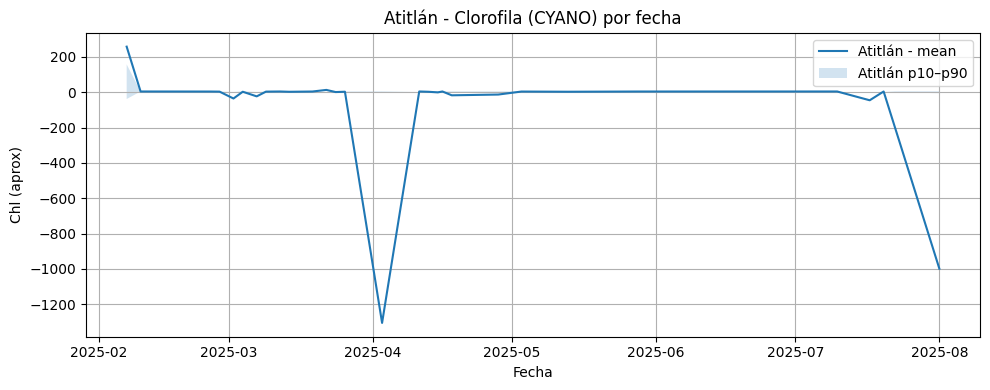

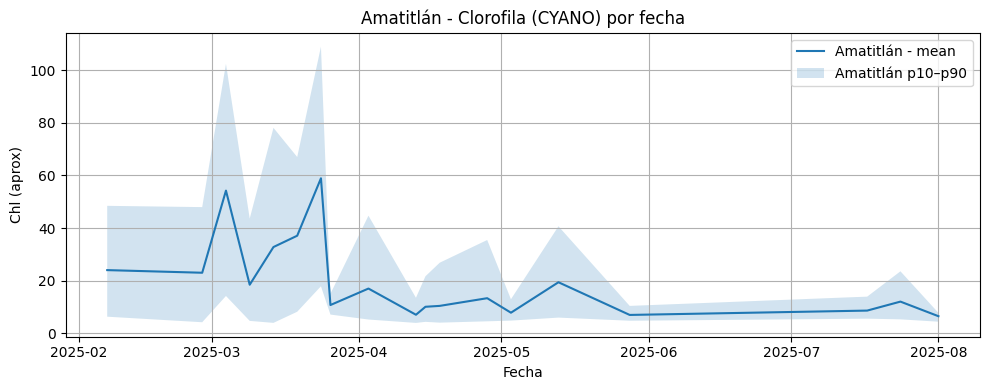

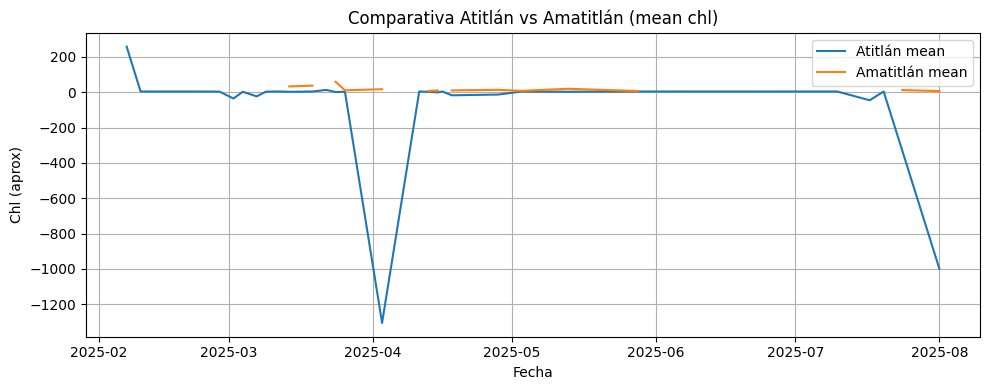

Figuras guardadas en: /content/drive/MyDrive/Colab_Notebooks/images/Resultados


In [ ]:
 # =========================
# PASO 6: Estadísticos y series temporales
# =========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


npz_atitlan   = "/content/drive/MyDrive/Colab_Notebooks/images/Atitlan/cyano_index/Atitlan_CYANO_stack.npz"
npz_amatitlan = "/content/drive/MyDrive/Colab_Notebooks/images/Amatitlan/cyano_index/Amatitlan_CYANO_stack.npz"


out_base = "/content/drive/MyDrive/Colab_Notebooks/images/Resultados"
os.makedirs(out_base, exist_ok=True)

def summarize_npz(npz_path: str, lake_name: str) -> pd.DataFrame:
    """Carga un stack NPZ (t, h, w) y resume por fecha (ignorando NaN)."""
    npz = np.load(npz_path, allow_pickle=True)
    data  = npz["data"]     # (t, h, w) con NaN fuera de agua/vegetación
    dates = npz["dates"]    # array de strings 'YYYY-MM-DD'
    # nodata = npz["nodata"]  # por si lo necesitas

    rows = []
    for i, d in enumerate(dates):
        arr = data[i]
        # Aplanar y quitar NaN
        v = arr[~np.isnan(arr)]
        if v.size == 0:
            mean = median = std = p10 = p90 = np.nan
            valid = 0
        else:
            mean   = float(np.nanmean(v))
            median = float(np.nanmedian(v))
            std    = float(np.nanstd(v, ddof=1)) if v.size > 1 else 0.0
            p10    = float(np.nanpercentile(v, 10))
            p90    = float(np.nanpercentile(v, 90))
            valid  = int(v.size)
        rows.append({
            "date": d,
            f"{lake_name}_mean": mean,
            f"{lake_name}_median": median,
            f"{lake_name}_std": std,
            f"{lake_name}_p10": p10,
            f"{lake_name}_p90": p90,
            f"{lake_name}_validpx": valid
        })
    df = pd.DataFrame(rows).sort_values("date")
    df["date"] = pd.to_datetime(df["date"])
    return df

# 6.1. Resumen por lago
df_atitlan   = summarize_npz(npz_atitlan,   "Atitlan")
df_amatitlan = summarize_npz(npz_amatitlan, "Amatitlan")

# 6.2. Guardar CSVs individuales
csv_atitlan   = os.path.join(out_base, "Atitlan_cyano_stats.csv")
csv_amatitlan = os.path.join(out_base, "Amatitlan_cyano_stats.csv")
df_atitlan.to_csv(csv_atitlan, index=False)
df_amatitlan.to_csv(csv_amatitlan, index=False)
print("Guardados:", csv_atitlan, "y", csv_amatitlan)

# 6.3. Unir por fecha (outer join para no perder fechas)
df_all = pd.merge(df_atitlan, df_amatitlan, on="date", how="outer").sort_values("date")
csv_all = os.path.join(out_base, "Lagos_cyano_stats_merged.csv")
df_all.to_csv(csv_all, index=False)
print("Guardado combinado:", csv_all)

# 6.4. (Opcional) Suavizado con media móvil de 3 observaciones
for col in [c for c in df_all.columns if c.endswith("_mean")]:
    df_all[col + "_roll3"] = df_all[col].rolling(window=3, min_periods=1, center=True).mean()

# 6.5. Gráficas (una por serie)
plt.figure(figsize=(10,4))
plt.plot(df_atitlan["date"], df_atitlan["Atitlan_mean"], label="Atitlán - mean")
plt.fill_between(df_atitlan["date"], df_atitlan["Atitlan_p10"], df_atitlan["Atitlan_p90"], alpha=0.2, label="Atitlán p10–p90")
plt.title("Atitlán - Clorofila (CYANO) por fecha")
plt.xlabel("Fecha")
plt.ylabel("Chl (aprox)")
plt.legend()
plt.grid(True)
fig1_path = os.path.join(out_base, "Atitlan_timeseries.png")
plt.tight_layout(); plt.savefig(fig1_path, dpi=150)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df_amatitlan["date"], df_amatitlan["Amatitlan_mean"], label="Amatitlán - mean")
plt.fill_between(df_amatitlan["date"], df_amatitlan["Amatitlan_p10"], df_amatitlan["Amatitlan_p90"], alpha=0.2, label="Amatitlán p10–p90")
plt.title("Amatitlán - Clorofila (CYANO) por fecha")
plt.xlabel("Fecha")
plt.ylabel("Chl (aprox)")
plt.legend()
plt.grid(True)
fig2_path = os.path.join(out_base, "Amatitlan_timeseries.png")
plt.tight_layout(); plt.savefig(fig2_path, dpi=150)
plt.show()

# 6.6. Comparativa en la misma escala (dos curvas en un gráfico)
plt.figure(figsize=(10,4))
plt.plot(df_all["date"], df_all["Atitlan_mean"],   label="Atitlán mean")
plt.plot(df_all["date"], df_all["Amatitlan_mean"], label="Amatitlán mean")
plt.title("Comparativa Atitlán vs Amatitlán (mean chl)")
plt.xlabel("Fecha")
plt.ylabel("Chl (aprox)")
plt.legend()
plt.grid(True)
fig3_path = os.path.join(out_base, "Comparativa_timeseries.png")
plt.tight_layout(); plt.savefig(fig3_path, dpi=150)
plt.show()

print("Figuras guardadas en:", out_base)


In [ ]:
import os, pandas as pd

base_res = "/content/drive/MyDrive/Colab_Notebooks/images/Resultados"

# Si ya tienes los DataFrames en memoria, comenta estas dos líneas y usa los que ya tienes:
df_atitlan   = pd.read_csv(os.path.join(base_res, "Atitlan_cyano_stats.csv"), parse_dates=["date"]) if os.path.exists(os.path.join(base_res, "Atitlan_cyano_stats.csv")) else df_atitlan
df_amatitlan = pd.read_csv(os.path.join(base_res, "Amatitlan_cyano_stats.csv"), parse_dates=["date"]) if os.path.exists(os.path.join(base_res, "Amatitlan_cyano_stats.csv")) else df_amatitlan

df_atitlan  = df_atitlan.sort_values("date")
df_amatitlan = df_amatitlan.sort_values("date")

print("Atitlán: filas =", len(df_atitlan))
display(df_atitlan.head(3))
print("Amatitlán: filas =", len(df_amatitlan))
display(df_amatitlan.head(3))


Atitlán: filas = 29


,date,Atitlan_mean,Atitlan_median,Atitlan_std,Atitlan_p10,Atitlan_p90,Atitlan_validpx
0,2025-02-07,257.803650,4.746404,1.132549e+06,-38.548668,157.722931,980272
1,2025-02-10,4.070998,4.071000,5.123178e-02,4.071000,4.071000,3173055
2,2025-02-25,3.787551,4.071000,1.429344e+02,4.071000,4.071000,3367982


Amatitlán: filas = 19


,date,Amatitlan_mean,Amatitlan_median,Amatitlan_std,Amatitlan_p10,Amatitlan_p90,Amatitlan_validpx
0,2025-02-07,23.989712,20.028362,19.238525,6.263997,48.446640,121251
1,2025-02-27,22.989000,17.961296,17.745512,4.158094,47.962700,130837
2,2025-03-04,54.240570,48.725872,33.463604,14.149116,102.470238,114683


In [ ]:
import numpy as np

def detectar_picos(df, col_mean):
    q1 = np.nanpercentile(df[col_mean], 25)
    q3 = np.nanpercentile(df[col_mean], 75)
    iqr = q3 - q1
    thr = q3 + 1.5*iqr
    peaks = df[df[col_mean] >= thr][["date", col_mean]].sort_values(col_mean, ascending=False)
    return peaks, thr

peaks_atitlan, thr_a = detectar_picos(df_atitlan, "Atitlan_mean")
peaks_amatitlan, thr_m = detectar_picos(df_amatitlan, "Amatitlan_mean")

print(f"Umbral Atitlán: {thr_a:.3f}")
display(peaks_atitlan)
print(f"Umbral Amatitlán: {thr_m:.3f}")
display(peaks_amatitlan)


Umbral Atitlán: 30.090


,date,Atitlan_mean
0,2025-02-07,257.80365


Umbral Amatitlán: 44.753


,date,Amatitlan_mean
6,2025-03-24,58.932041
2,2025-03-04,54.240570


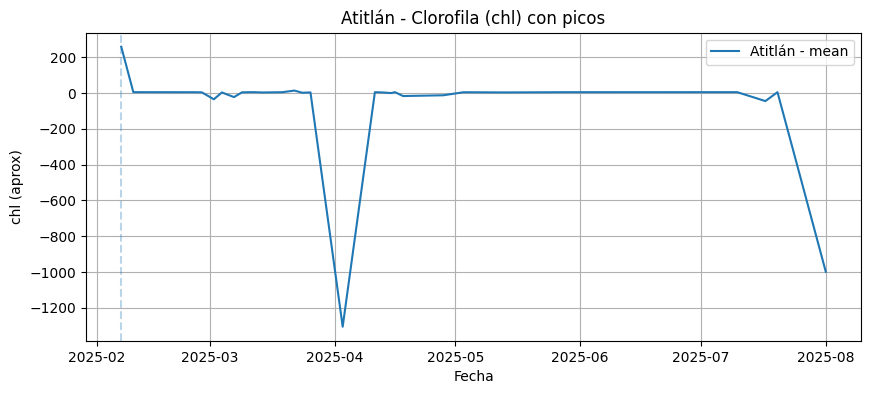

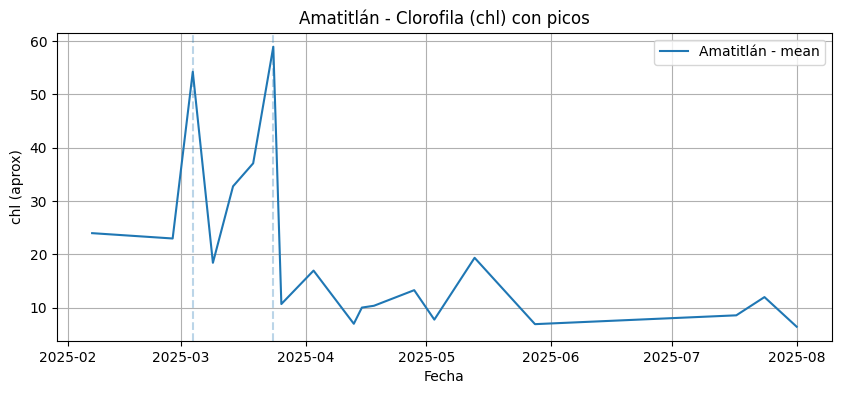

In [ ]:
import matplotlib.pyplot as plt

# Asegúrate de tener df_atitlan y df_amatitlan cargados/ordenados
plt.figure(figsize=(10,4))
plt.plot(df_atitlan["date"], df_atitlan["Atitlan_mean"], label="Atitlán - mean")
for d in peaks_atitlan["date"]:
    plt.axvline(d, linestyle="--", alpha=0.3)
plt.title("Atitlán - Clorofila (chl) con picos")
plt.xlabel("Fecha"); plt.ylabel("chl (aprox)"); plt.grid(True); plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df_amatitlan["date"], df_amatitlan["Amatitlan_mean"], label="Amatitlán - mean")
for d in peaks_amatitlan["date"]:
    plt.axvline(d, linestyle="--", alpha=0.3)
plt.title("Amatitlán - Clorofila (chl) con picos")
plt.xlabel("Fecha"); plt.ylabel("chl (aprox)"); plt.grid(True); plt.legend()
plt.show()
